In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Define the directory where your preprocessed images are stored
base_dir = ('/content/drive/MyDrive/PTrained')

Epoch 1/20
17/17 [==============================] - 49s 3s/step - loss: 3.7928 - accuracy: 0.5704 - val_loss: 0.6957 - val_accuracy: 0.8382
Epoch 2/20
17/17 [==============================] - 44s 3s/step - loss: 0.3240 - accuracy: 0.8963 - val_loss: 0.5694 - val_accuracy: 0.8382
Epoch 3/20
17/17 [==============================] - 45s 3s/step - loss: 0.0918 - accuracy: 0.9685 - val_loss: 0.4614 - val_accuracy: 0.8750
Epoch 4/20
17/17 [==============================] - 44s 3s/step - loss: 0.0240 - accuracy: 0.9944 - val_loss: 0.4906 - val_accuracy: 0.8162
Epoch 5/20
17/17 [==============================] - 44s 3s/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.4205 - val_accuracy: 0.8676
Epoch 6/20
17/17 [==============================] - 42s 2s/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.3736 - val_accuracy: 0.8676
Epoch 7/20
17/17 [==============================] - 44s 3s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.4644 - val_accuracy: 0.8456
Epoch 8/20
17/17 [==

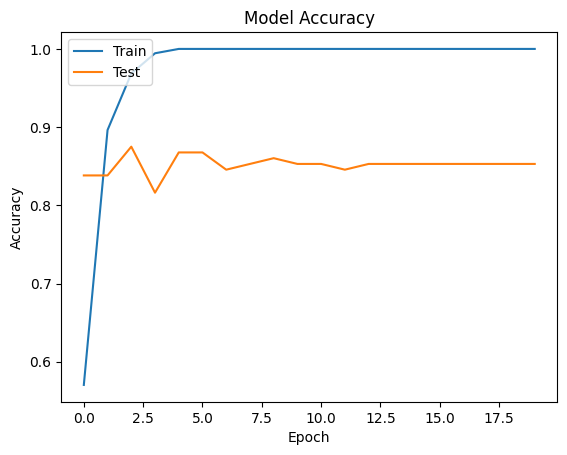

In [ ]:
# Define the image size
image_size = (128, 128)
import random
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
# Define the mapping between folder names and labels
label_mapping = {
    'Healthy':0,
    'Very_early_blight':1,
    'Early_blight':2,
    'middle_blight':3,
    'Late_blight':4,
    'Very_late_blight':5,
}

# Create empty lists to store images and labels
images = []
labels = []

# Define the number of images to use for each class
num_images_per_class = 1460  # Set the desired number of images per class

# Iterate over disease folders
for folder, label in label_mapping.items():
    # Construct the full path of the disease folder
    folder_path = os.path.join(base_dir, folder)

    # Get the list of image files within the disease folder
    image_files = os.listdir(folder_path)

    # Shuffle the image files
    np.random.shuffle(image_files)

    # Iterate over image files
    for i, file_name in enumerate(image_files):
        # Check if the desired number of images per class is reached
        if i >= num_images_per_class:
            break

        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)

        # Load the image
        image = cv2.imread(file_path)

        # Resize the image
        resized_image = cv2.resize(image, image_size)

        # Append the resized image to the list of images
        images.append(resized_image)

        # Append the label to the list of labels
        labels.append(label)


# Convert the images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Encode labels into integer values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Perform one-hot encoding on the labels
num_classes = len(label_mapping)
labels = to_categorical(labels, num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create a ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Save the entire model as a SavedModel
model.save('model_saved')

# Save the label encoder classes
np.save('label_encoder_classes.npy', label_encoder.classes_)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Generate predictions on the testing set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1 score
classification_rep = classification_report(y_test, y_pred, target_names=label_mapping.keys())
print("Classification Report:")
print(classification_rep)

# Plot accuracy metrics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Randomly select one image from each class for testing
random_test_images = []
random_test_labels = []
for class_label in range(num_classes):
    class_indices = np.where(y_test == class_label)[0]
    random_index = np.random.choice(class_indices)
    random_test_images.append(X_test[random_index])
    # Get the corresponding class name from label_mapping
    class_name = next(key for key, value in label_mapping.items() if value == class_label)
    random_test_labels.append(class_name)

# Convert random test data to NumPy arrays
random_test_images = np.array(random_test_images)
random_test_labels = np.array(random_test_labels)

# Predict on the random test data
random_test_predictions = model.predict(random_test_images)
random_test_predictions = np.argmax(random_test_predictions, axis=1)


# Map numerical predictions back to class names
predicted_labels = [next(key for key, value in label_mapping.items() if value == pred) for pred in random_test_predictions]

# Display random test predictions
print("Random Test Predictions:")
for i, prediction in enumerate(predicted_labels):
    print(f"Predicted Label: {prediction}, True Label: {random_test_labels[i]}")

1/1 [==============================] - 0s 337ms/step
Random Test Predictions:
Predicted Label: Healthy, True Label: Healthy
Predicted Label: Very_early_blight, True Label: Very_early_blight
Predicted Label: Early_blight, True Label: Early_blight
Predicted Label: middle_blight, True Label: middle_blight
Predicted Label: Late_blight, True Label: Late_blight
Predicted Label: Very_late_blight, True Label: Very_late_blight


In [ ]:
# Function to detect blight disease in a random image
def detect_random_image(image_path):
    # Load the saved model
    model = keras.models.load_model('model_saved')

    # Load the label encoder classes
    label_encoder_classes = np.load('label_encoder_classes.npy', allow_pickle=True)
    label_encoder = LabelEncoder()
    label_encoder.classes_ = label_encoder_classes

    # Load and preprocess the image
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, image_size)
    resized_image = np.expand_dims(resized_image, axis=0)

    # Predict the class
    prediction = model.predict(resized_image)
    predicted_class = np.argmax(prediction, axis=1)
    class_name = label_encoder.inverse_transform(predicted_class)[0]

    # Map the class number back to the class name
    class_name_mapping = {v: k for k, v in label_mapping.items()}
    class_label = class_name_mapping[class_name]

    print(f"Predicted class for the image is: {class_label}")

# Test the function with a random image
random_image_path = '/content/tomato_healthy_635.JPG' # Update this path to a random image
detect_random_image(random_image_path)

1/1 [==============================] - 1s 1s/step
Predicted class for the image is: Healthy
